### COVID-19 cases in Maranhão


The [original notebook for the map](https://github.com/lubianat/covid_19_sandbox/blob/master/sao_paulo_covid/Map%20of%20Covid-19%20Cases%20in%20S%C3%A3o%20Paulo.ipynb) was made by Tiago Lubiana for São Paulo state, this is merely an adaption, so thank him!

In [1]:
import pandas as pd
from datetime import date,datetime, timedelta
import numpy as np

Data acquired from [here](https://www.corona.ma.gov.br/)

In [4]:
import requests
from bs4 import BeautifulSoup as BS

url = 'https://www.corona.ma.gov.br/'
response = requests.get(url)
soup = BS(response.content, "html.parser")
obt = soup.find('span', {'id': 'maranhao-obito'})

In [5]:
muns = soup.find('table', {'class': 'stats__table'})
muns = pd.read_html(str(muns))[0]
muns.columns = ["municipio", "Confirmados", "Óbitos", "Letalidade"]

In [6]:
import unidecode
muns['municipio'] = [unidecode.unidecode(m.upper()) for m in muns['municipio']]
muns

,municipio,Confirmados,Óbitos,Letalidade
0,SAO LUIS,582,34,5.84%
1,ACAILANDIA,1,0,0%
2,ALTAMIRA DO MARANHAO,1,0,0%
3,CACHOEIRA GRANDE,1,0,0%
4,CAJAPIO,1,0,0%
5,CANTANHEDE,1,0,0%
6,CAXIAS,2,0,0%
7,CHAPADINHA,1,0,0%
8,COLINAS,1,0,0%
9,DAVINOPOLIS,1,0,0%


In [7]:
data = soup.find('em', {'class': 'stats__fonte'})
data = data.string.replace('\n                    Fonte: Secretaria de Estado da Saúde - Data: ', "").replace(' às 20:30\n                ', '')

data = datetime.strptime(data, "%d/%m/%Y").strftime("+%Y-%m-%dT00:00:00Z/11")
data

'+2020-04-15T00:00:00Z/11'

In [8]:
import geopandas as gpd
mapa_dos_municipios = gpd.read_file("../../estados_shapes/unzipped/21MUE250GC_SIR.shp")
mapa_dos_municipios.columns = ['municipio', 'idMunicipio', 'geometry']
mapa_dos_municipios['municipio'] = [unidecode.unidecode(m.upper()) for m in mapa_dos_municipios['municipio']]
mapa_dos_municipios.head()

,municipio,idMunicipio,geometry
0,ACAILANDIA,2100055,"POLYGON ((-47.07274 -4.23663, -47.07000 -4.245..."
1,AFONSO CUNHA,2100105,"POLYGON ((-43.21035 -4.36534, -43.21433 -4.362..."
2,AGUA DOCE DO MARANHAO,2100154,"POLYGON ((-42.30928 -3.09248, -42.26533 -3.010..."
3,ALCANTARA,2100204,"MULTIPOLYGON (((-44.44895 -2.13239, -44.45161 ..."
4,ALDEIAS ALTAS,2100303,"POLYGON ((-43.21035 -4.36534, -43.21001 -4.365..."


In [9]:
map_conf = pd.merge(mapa_dos_municipios, muns, on='municipio', how='left')
map_conf

,municipio,idMunicipio,geometry,Confirmados,Óbitos,Letalidade
0,ACAILANDIA,2100055,"POLYGON ((-47.07274 -4.23663, -47.07000 -4.245...",1.0,0.0,0%
1,AFONSO CUNHA,2100105,"POLYGON ((-43.21035 -4.36534, -43.21433 -4.362...",NaN,NaN,NaN
2,AGUA DOCE DO MARANHAO,2100154,"POLYGON ((-42.30928 -3.09248, -42.26533 -3.010...",NaN,NaN,NaN
3,ALCANTARA,2100204,"MULTIPOLYGON (((-44.44895 -2.13239, -44.45161 ...",NaN,NaN,NaN
4,ALDEIAS ALTAS,2100303,"POLYGON ((-43.21035 -4.36534, -43.21001 -4.365...",NaN,NaN,NaN
...,...,...,...,...,...,...
212,VIANA,2112803,"POLYGON ((-45.09566 -2.93148, -45.12020 -2.972...",1.0,0.0,0%
213,VILA NOVA DOS MARTIRIOS,2112852,"POLYGON ((-47.93735 -5.23958, -47.94246 -5.239...",NaN,NaN,NaN
214,VITORIA DO MEARIM,2112902,"POLYGON ((-44.81751 -3.67823, -44.82005 -3.678...",1.0,0.0,0%
215,VITORINO FREIRE,2113009,"POLYGON ((-45.33985 -3.86996, -45.33990 -3.870...",NaN,NaN,NaN


In [10]:
map_conf["Confirmados"] = map_conf["Confirmados"].fillna(0)
map_conf["Confirmados"] = map_conf["Confirmados"].astype(float)

In [11]:
map_conf["casos_categorizados"] = pd.cut(map_conf["Confirmados"],
                                                    bins = [-1,1, 10,50,500,1000],
                                                   labels = ["0", "1-10", "11-50", "51-500",">500"])
map_conf

,municipio,idMunicipio,geometry,Confirmados,Óbitos,Letalidade,casos_categorizados
0,ACAILANDIA,2100055,"POLYGON ((-47.07274 -4.23663, -47.07000 -4.245...",1.0,0.0,0%,0
1,AFONSO CUNHA,2100105,"POLYGON ((-43.21035 -4.36534, -43.21433 -4.362...",0.0,NaN,NaN,0
2,AGUA DOCE DO MARANHAO,2100154,"POLYGON ((-42.30928 -3.09248, -42.26533 -3.010...",0.0,NaN,NaN,0
3,ALCANTARA,2100204,"MULTIPOLYGON (((-44.44895 -2.13239, -44.45161 ...",0.0,NaN,NaN,0
4,ALDEIAS ALTAS,2100303,"POLYGON ((-43.21035 -4.36534, -43.21001 -4.365...",0.0,NaN,NaN,0
...,...,...,...,...,...,...,...
212,VIANA,2112803,"POLYGON ((-45.09566 -2.93148, -45.12020 -2.972...",1.0,0.0,0%,0
213,VILA NOVA DOS MARTIRIOS,2112852,"POLYGON ((-47.93735 -5.23958, -47.94246 -5.239...",0.0,NaN,NaN,0
214,VITORIA DO MEARIM,2112902,"POLYGON ((-44.81751 -3.67823, -44.82005 -3.678...",1.0,0.0,0%,0
215,VITORINO FREIRE,2113009,"POLYGON ((-45.33985 -3.86996, -45.33990 -3.870...",0.0,NaN,NaN,0


In [12]:
map_conf.query("municipio == 'SAO LUIS'")

,municipio,idMunicipio,geometry,Confirmados,Óbitos,Letalidade,casos_categorizados
185,SAO LUIS,2111300,"POLYGON ((-44.22225 -2.47364, -44.21895 -2.474...",582.0,34.0,5.84%,>500


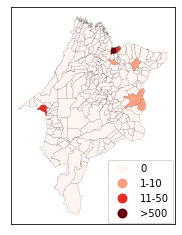

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = map_conf.plot(column='casos_categorizados',
                         categorical=True, 
                         legend=True, 
                         figsize=(10,6),
                         markersize=46,
                         cmap = "Reds",
                         edgecolor='k',
                         linewidth=0.1,
                         ax=ax)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.02, 0.12, 1, 0.2))
plt.savefig("figs/casos_ma_" + "13_april" + ".png", dpi = 300)